# Exemple de krigeage 1D avec enrichissement séquentiel

## Remerciements

Merci à Régis Lebrun pour son aide sur ce thème.

## Références

* Metamodeling with Gaussian processes, Bertrand Iooss, EDF R&D, 2014, www.gdr-mascotnum.fr/media/sssamo14_iooss.pdf
* https://github.com/openturns/www/blob/master/_images/scripts/plot_kriging.py
* http://trac.openturns.org/ticket/961
* http://trac.openturns.org/ticket/959
* http://trac.openturns.org/ticket/960

## Résumé

Ce segment détaille la création d'un métamodèle de krigeage pour une fonction dont l'entrée et la sortie sont des variables réelles scalaires. Il expose d'abord la constitution des bases d'apprentissage et de validation. Ensuite, il décrit la configuration du modèle par le choix d'une tendance et d'une covariance. Enfin, il explique la méthode d'évaluation d'un intervalle de confiance fondé sur la variance de krigeage.

## Introduction

Dans cet exemple, nous considérons la fonction sinus :
$$
y = \sin(x)
$$
pour $x\in[0,12]$. 

Nous souhaitons réaliser un métamodèle de cette fonction. Dans ce but, nous considérons un ensemble de $n$ observations de la fonction :
$$
y_i = \sin(x_i)
$$
pour $i \in \{1, \ldots, 7\}$, où $x_i$ est la i-ème abscisse et $y_i$ est l'ordonnée correspondante. 

Pour cela, nous considérons les 7 abscisses suivantes.

| $i$ | 1 | 2 | 3 | 4 | 5 | 6 | 7 |
|---|---|---|---|---|---|---|---|
| $x_i$ | 1 | 3 | 4 | 6 | 7.9 | 11 | 11.5 |

**Tableau 1** : Plan d'expériences initial.

Nous allons considérer un métamodèle de krigeage associé à :
* une tendance constante,
* un noyau de covariance de Matérn. 

## Création du métamodèle

Nous allons créer le méta-modèle avec OpenTURNS. Nous commençons par définir la fonction `g` comme une fonction symbolique. Puis nous définissons la variable `xTrain` qui contient les abscisses du plan d'expériences, c'est à dire le plan d'expériences d'apprentissage. Puis, nous calculons les ordonnées `yTrain` correspondantes. La variable `nTrain` contient la taille de la base d'apprentissage.

In [1]:
import numpy as np
import openturns as ot
import openturns.experimental as otexp
import openturns.viewer as otv

In [2]:
g = ot.SymbolicFunction(["x"], ["sin(x)"])

xTrain = ot.Sample.BuildFromPoint([1.0, 3.0, 4.0, 6.0, 7.9, 11.0, 11.5])
yTrain = g(xTrain)
nTrain = xTrain.getSize()
nTrain

7

Pour comparer la fonction et son métamodèle, nous allons utiliser une base de validation constituée d'une grille régulière de 100 points régulièrement répartis entre 0 et 12. Puis nous convertissons cette base en échantillon et nous calculons les valeurs de la fonction en ces points.  

In [3]:
def linearSample(xMin, xMax, numberOfPoints):
    """Returns a sample created from a regular grid
    from xMin to xMax with numberOfPoints points."""
    step = (xMax - xMin) / (numberOfPoints - 1)
    rg = ot.RegularGrid(xMin, step, numberOfPoints)
    sample = rg.getVertices()
    return sample

In [4]:
xMin = -0.5
xMax = 12.5
nTest = 100
xTest = linearSample(xMin, xMax, nTest)
yTest = g(xTest)

Pour observer la fonction et la position des points de la base d'apprentissage, nous réalisons le graphique suivant.

In [5]:
def plotDataTest(xTest, yTest, color="gray50"):
    """Plot the data (xTest,yTest) as a Curve, in dashed black"""
    curve = ot.Curve(xTest, yTest)
    curve.setLegend("Exact")
    curve.setColor(color)
    curve.setLineStyle("dashed")
    return curve

In [6]:
def plotDataTrain(xTrain, yTrain, color="firebrick3"):
    """Plot the data (xTrain,yTrain) as a Cloud, in red"""
    cloud = ot.Cloud(xTrain, yTrain)
    cloud.setColor(color)
    cloud.setPointStyle("o")
    cloud.setLegend("Donnees")
    return cloud

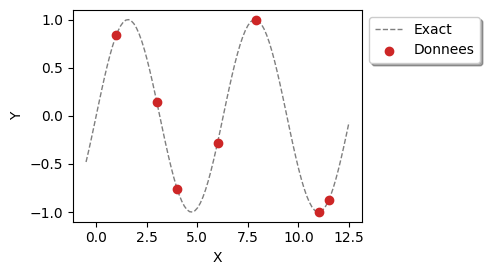

In [7]:
graph = ot.Graph()
graph.add(plotDataTest(xTest, yTest))
graph.add(plotDataTrain(xTrain, yTrain))
graph.setAxes(True)
graph.setXTitle("X")
graph.setYTitle("Y")
graph.setLegendPosition("upper left")
graph.setLegendCorner((1.0, 1.0))
view = otv.View(graph, figure_kw={"figsize": (5.0, 3.0)})

Ce graphique initial met en exergue la discrétisation du phénomène physique étudié. On observe que le plan d'expériences est irrégulier : certaines zones (entre $x=3$ et $x=6$ et surtout les deux points en $x=11$ et $x=11.5$) sont relativement denses, tandis que d'autres présentent des lacunes significatives (entre $x=8$ et $x=11$). Cette répartition hétérogène des observations est un cas d'étude classique pour tester la capacité du krigeage à interpoler les données tout en identifiant les zones de forte incertitude résiduelle.

Pour définir la tendance, nous utilisons la classe `ConstantBasisFactory`. La classe `MatérnModel` permet de créer un modèle de covariance de Matérn, associé au paramètre $\nu=3/2$.

In [8]:
dimension = 1
basis = ot.ConstantBasisFactory(dimension).build()
covarianceModel = ot.MaternModel([1.0] * dimension, 1.5)
fitter = otexp.GaussianProcessFitter(xTrain, yTrain, covarianceModel, basis)
fitter.run()
gpr = otexp.GaussianProcessRegression(fitter.getResult())
gpr.run()
gprResult = gpr.getResult()
print(gprResult)

GaussianProcessRegressionResult(covariance models=MaternModel(scale=[1.27446], amplitude=[0.822252], nu=1.5), covariance coefficients=0 : [  1.13908    ]
1 : [  1.01757    ]
2 : [ -1.76275    ]
3 : [ -0.559143   ]
4 : [  1.78756    ]
5 : [ -1.6194     ]
6 : [ -0.00292259 ], basis=Basis( [[x0]->[1]] ), trend coefficients=[0.00736634])


On observe que les paramètres d'échelle `scale` et d'amplitude ont été optimisés par la méthode `run`. Puis, on récupère le métamodèle avec la méthode `getMetaModel` et on évalue la valeur du métamodèle sur la base de validation.

In [9]:
gprMetaModel = gprResult.getMetaModel()
yTestMetaModel = gprMetaModel(xTest)

Dans le but de comparer la valeur du méta-modèle avec la valeur du modèle sur la base de validation, on réalise le graphique suivant. 

In [10]:
def plotDataGPR(xTest, yTestMetaModel, color="dodgerblue3"):
    """Plots (xTest,yTestMetaModel) from the metamodel as a Curve, in blue"""
    curve = ot.Curve(xTest, yTestMetaModel)
    curve.setColor(color)
    curve.setLegend("Krigeage")
    return curve

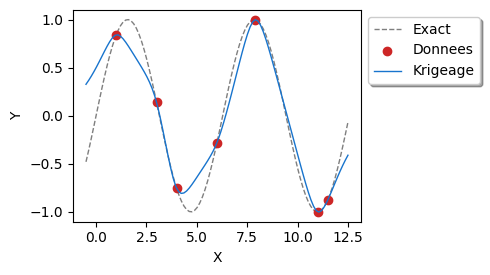

In [11]:
graph = ot.Graph()
graph.add(plotDataTest(xTest, yTest))
graph.add(plotDataTrain(xTrain, yTrain))
graph.add(plotDataGPR(xTest, yTestMetaModel))
graph.setAxes(True)
graph.setXTitle("X")
graph.setYTitle("Y")
graph.setLegendPosition("upper left")
graph.setLegendCorner((1.0, 1.0))
view = otv.View(graph, figure_kw={"figsize": (5.0, 3.0)})

L'examen du métamodèle révèle une propriété fondamentale du krigeage : il s'agit d'un interpolateur exact. La courbe passe strictement par les points d'apprentissage. Toutefois, on constate un écart notable avec la fonction exacte dans les zones de forte courbure ou entre deux points éloignés. Le métamodèle peine ici à capturer la dynamique locale de la fonction sinus, ce qui justifie la nécessité d'une évaluation de l'erreur de prédiction _via_ la variance conditionnelle.

On observe que, lorsque la fonction sinus a une forte courbure entre deux points d'apprentissage assez espacés, alors le métamodèle de krigeage n'est pas très proche de la fonction g. Pour cela on peut estimer la variance de krigeage et calculer un intervalle de confiance gaussien à 95% contenant le processus gaussien. 

On commence par définir la variable `alpha` contenant le complémentaire du niveau souhaité pour l'intervalle de confiance. Puis on calcule le quantile de la loi gaussienne correspondant à `1-alpha/2`. Ainsi l'intervalle de confiance est 
$$
\mathbb{P}\left(Y(x_0)\in\left[\mu_{\hat{Y}}(x_0) + z_{\alpha/2}\sigma_{\hat{Y}}(x_0), \mu_{\hat{Y}}(x_0) + z_{1-\alpha/2}\sigma_{\hat{Y}}(x_0)\right]\right)=1-\alpha
$$
où $z_{\alpha/2}$ est le quantile de niveau $1 - \alpha/2$ de la loi gaussienne de moyenne nulle et d'écart-type 1.

In [12]:
normalDistribution = ot.Normal()
alpha = 0.05
bilateralCI = normalDistribution.computeBilateralConfidenceInterval(1 - alpha)
print(f"alpha={alpha:f}")
quantileAlpha = bilateralCI.getUpperBound()[0]
print(f"Quantile alpha={quantileAlpha:f}")

alpha=0.050000
Quantile alpha=1.959964


Pour estimer l'erreur de krigeage, on peut considérer l'évolution de la variance conditionnelle. La méthode `getConditionalCovariance` renvoie la matrice de covariance `covGrid` évaluée en les points en argument de la méthode. Puis, on peut utiliser les termes diagonaux de cette matrice pour accéder à la variance de krigeage. Puisque c'est une variance, nous utilisons la racine carrée pour évaluer un écart-type, dont l'unité est comparable avec celle de la sortie. Depuis OT 1.14, on peut utiliser la méthode getConditionalMarginalVariance, qui retourne la partie diagonale de la matrice de covariance.

In [13]:
conditional = otexp.GaussianProcessConditionalCovariance(gprResult)
covGrid = conditional.getConditionalMarginalVariance(xTest)
conditionalStDev = np.sqrt(covGrid)

La figure suivante présente l'écart-type conditionnel en fonction de $x$.

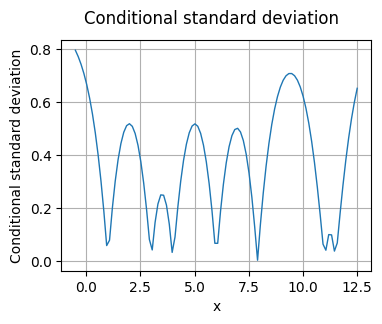

In [14]:
graph = ot.Graph(
    "Conditional standard deviation", "x", "Conditional standard deviation", True, ""
)
curve = ot.Curve(xTest, conditionalStDev)
graph.add(curve)
graph.setLegendPosition("upper left")
graph.setLegendCorner((1.0, 1.0))
view = otv.View(graph, figure_kw={"figsize": (4.0, 3.0)})

Le profil de l'écart-type conditionnel illustre la confiance que le modèle accorde à ses propres prédictions. Conformément à la théorie, l'incertitude s'annule aux abscisses des points d'apprentissage, car l'information y est supposée parfaite. À l'inverse, l'incertitude atteint ses maxima locaux au centre des intervalles dépourvus de données. Cette structure en "cloches" fournit un critère objectif pour l'enrichissement séquentiel du plan d'expériences : l'ajout d'un point au point d'abscisse maximisant cette valeur réduira l'incertitude globale de manière optimale.

Pour créer le graphique des bornes de l'intervalle de confiance, on utilise la classe `Polygon` dans le but de créer une surface colorée associée à l'intervalle de confiance. Pour cela, on commence par générer les sommets des polygones en bas `vLow` et en haut `vUp`. Puis on assemble les sommets pour former les polygones. 

In [15]:
def plotGPRBounds(
    gprResult, xTest, color="darkorange1", alphaLevel=0.95, alphaTransparency=0.5
):
    """
    Plot normal confidence bounds of a GPR

    Parameters
    ----------
    gprResult : ot.GaussianProcessResult
        The GPR
    xTest : ot.Sample
        The x testing points
    color : str
        The color
    alphaLevel : float, in [0, 1]
        The confidence level
    alphaTransparency : float, in [0, 1]
        The transparency

    Returns
    -------
    boundsPoly : ot.PolygonArray
        The colored area.
    """
    conditional = otexp.GaussianProcessConditionalCovariance(gprResult)
    covGrid = conditional.getConditionalMarginalVariance(xTest)
    gprMetaModel = gprResult.getMetaModel()
    yTestMetaModel = gprMetaModel(xTest)
    normalDistribution = ot.Normal()
    bilateralCI = normalDistribution.computeBilateralConfidenceInterval(alphaLevel)
    quantileAlpha = bilateralCI.getUpperBound()[0]
    conditionalStDev = np.sqrt(covGrid)
    dataLower = yTestMetaModel - conditionalStDev * quantileAlpha
    dataUpper = yTestMetaModel + conditionalStDev * quantileAlpha
    boundsPoly = ot.Polygon.FillBetween(xTest, dataLower, dataUpper)
    boundsPoly.setLegend("95% bounds")
    boundsPoly.setColor(color)
    boundsPoly.setAlpha(alphaTransparency)
    return boundsPoly

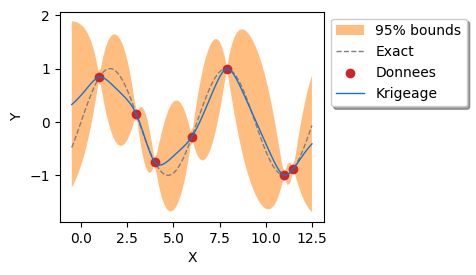

In [16]:
graph = ot.Graph()
graph.add(plotGPRBounds(gprResult, xTest))
graph.add(plotDataTest(xTest, yTest))
graph.add(plotDataTrain(xTrain, yTrain))
graph.add(plotDataGPR(xTest, yTestMetaModel))
graph.setAxes(True)
graph.setXTitle("X")
graph.setYTitle("Y")
graph.setLegendPosition("upper left")
graph.setLegendCorner((1.0, 1.0))
view = otv.View(graph, figure_kw={"figsize": (5.0, 3.0)})

Le graphique final présente l'intervalle de confiance à 95 % construit à partir du modèle de processus gaussien. On vérifie graphiquement la pertinence du modèle probabiliste : la fonction exacte (courbe grise) reste contenue à l'intérieur de l'enveloppe orange. La largeur de cet intervalle est directement proportionnelle à la variance de krigeage. Un intervalle étroit indique une zone où le métamodèle est fiable, tandis qu'un élargissement signale une zone de l'espace d'entrée où le modèle manque de connaissances.



On ne doit pas accorder une confiance totale aux intervalles de crédibilité produits par les intervalles du processus gaussien conditionné. Plus précisément, pour un point $x_0$ donné, on n'a pas la certitude que le niveau de couverture prédit par le processus gaussien est supérieur ou égal au niveau réellement atteint par le métamodèle. Une des raisons pour cela est que la fonction sinus n'est pas la réalisation d'un processus gaussien. Pour garantir un niveau de confiance supérieur ou égal au niveau requis, d'autres approches sont nécessaires, comme la prédiction conforme.

## Exercice 1 : Choix du prochain point

On observe que, pour certaines zones de l'espace, le krigeage est de moins bonne qualité. On peut le voir, bien sûr, en comparant la valeur prédite par le métamodèle et la valeur exacte. On observe de plus, que la variance de krigeage est souvent élevée dans les zones où le métamodèle est de mauvaise qualité. 

**Questions.**

* Si l'on devait choisir un huitième point et l'ajouter à la base d'apprentissage, comment pourrions-nous choisir ce point ? Pour cela, observer le graphique de l'écart-type conditionnel et identifier le point $x$ qui maximise cet écart-type. 
* Modifier la variable `xTrain` (au début de l'exemple) et ajouter le point d'entrée $x$ dans la liste. 
* Exécuter les cellules suivantes et observer:
    * dans le graphique présentant l'évolution de la fonction comparée à celle du krigeage, que le nouveau krigeage possède un nouveau point d'interpolation, 
    * dans le graphique présentant l'évolution de l'écart-type conditionnel en fonction de $x$, que l'écart-type est désormais nul en ce point, 
    * dans le graphique présentant l'évolution de la fonction et de son intervalle de confiance à 95%, que l'incertitude est désormais réduite en ce point. 
* Ajouter ainsi successivement 6 points dans le plan d'expériences. Qu'observez-vous ?
- Créer une fonction qui calcule un nouveau point à ajouter au plan. Cette fonction devra avoir la séquence d'appel `xNew = getNewPoint(xMin, xMax, gprResult)` où `xMin` et `xMax` sont les bornes et `xNew` est le point à ajouter.
- Réaliser une boucle itérative pour ajouter une douzaine de points. Le résultat est-il suffisamment précis ?
- Comment cela se généralise-t-il en dimension supérieure ?

Pour faciliter le travail, on pourra utiliser les deux fonctions suivantes. 

```python
def fitGPR(
    xTrain, yTrain, optimizeParameters=True, covarianceModel=None, nu=1.5, basis=None
):
    """Fit a Gaussian Process Regression model to the provided training data.

    This function configures and trains a kriging model using a constant basis
    and a Matern (3/2) covariance model. It automates the parameter adjustment
    process through the GaussianProcessFitter class to find the optimal
    hyperparameters.

    Parameters
    ----------
    xTrain : openturns.Sample
        The input training sample of dimension 1.
    yTrain : openturns.Sample
        The output training sample (observations) corresponding to the inputs.
    optimizeParameters : bool
        Set to False to disable optimization
    covarianceModel : ot.CovarianceModel
        By default, set a ot.MaternModel([1.0] * dimension, nu)
    nu : float, > 0.5
        The regularity parameter of the Matern covariance model
    basis : ot.Basis
        The basis.
        By default, set a ConstantBasis.

    Returns
    -------
    gprResult : otexp.GaussianProcessRegressionResult
        The object containing the fitting results, including the metamodel and
        the optimized covariance parameters.

    Examples
    --------
    >>> import openturns as ot
    >>> import openturns.experimental as otexp
    >>> X = ot.Sample([[1.0], [2.0], [3.0]])
    >>> Y = ot.Sample([[2.5], [3.7], [5.1]])
    >>> result = fitGPR(X, Y)
    """
    # Covariance model
    dimension = xTrain.getDimension()
    if basis is None:
        basis = ot.ConstantBasisFactory(dimension).build()
    if covarianceModel is None:
        covarianceModel = ot.MaternModel([1.0] * dimension, nu)
    # Fit the GP on the training data
    fitter = otexp.GaussianProcessFitter(xTrain, yTrain, covarianceModel, basis)
    print(f"Optimize={optimizeParameters}")
    fitter.setOptimizeParameters(optimizeParameters)
    fitter.run()
    gpr = otexp.GaussianProcessRegression(fitter.getResult())
    gpr.run()
    gprResult = gpr.getResult()
    return gprResult


def drawGPR(xTrain, yTrain, gprResult, xMin=-0.5, xMax=12.5, nTest=100):
    """Visualize the Gaussian Process Regression results and training data.

    This function creates a comprehensive plot comparing the original model,
    the GPR metamodel, the training data, and the prediction confidence bounds.
    It evaluates the metamodel over a specified range to generate the visual
    representation.

    Parameters
    ----------
    xTrain : openturns.Sample
        The training input samples used for the GPR fit.
    yTrain : openturns.Sample
        The corresponding training output observations.
    gprResult : otexp.GaussianProcessRegressionResult
        The result object from a prior GPR fit containing the metamodel.
    xMin : float, optional
        The lower bound of the plotting range. Default is -0.5.
    xMax : float, optional
        The upper bound of the plotting range. Default is 12.5.
    nTest : int, optional
        The number of points used to discretize the plotting grid. Default is 100.

    Returns
    -------
    graph : openturns.Graph
        A graphical object consolidating the data points, the metamodel curve,
        and the uncertainty intervals.

    Examples
    --------
    >>> import openturns as ot
    >>> # Assuming result is a GaussianProcessRegressionResult object
    >>> graph = drawGPR(X_train, Y_train, result)
    """
    # Create a grid to plot the function and the metamodel
    xTest = linearSample(xMin, xMax, nTest)
    yTest = g(xTest)
    #
    gprMetaModel = gprResult.getMetaModel()
    yTestMetaModel = gprMetaModel(xTest)
    # Plot
    graph = ot.Graph()
    graph.add(plotGPRBounds(gprResult, xTest))
    graph.add(plotDataTest(xTest, yTest))
    graph.add(plotDataTrain(xTrain, yTrain))
    graph.add(plotDataGPR(xTest, yTestMetaModel))
    graph.setAxes(True)
    graph.setXTitle("X")
    graph.setYTitle("Y")
    graph.setTitle(f"Sample size = {xTrain.getSize()}")
    graph.setLegendPosition("upper left")
    graph.setLegendCorner((1.0, 1.0))
    return graph

```

## Exercice 2 : Impact de l'estimation des hyperparamètres

L'instance de la classe `GaussianProcessFitter` dispose d'une méthode `setOptimizeParameters` qui permet d'activer ou désactiver l'estimation des hyperparamètres du modèle de covariance par la méthode du maximum de vraisemblance. 

**Questions.**

* Désactiver cette optimisation avec l'instruction :
```python
fitter.setOptimizeParameters(False)
```
et observer le résultat.
* Quel est l'impact sur les hyperparamètres `scale` et `amplitude` ?
* Quel est l'impact sur l'espérance conditionnelle ?
* Quel est l'impact sur la variance conditionnelle ?

## Exercice 3 : Impact du modèle de covariance

Dans l'exemple, nous avons utilisé le modèle de Matérn comme modèle de covariance. 

**Questions.**

* Utiliser le modèle `SquaredExponential` avec les paramètres suivants 

```python
covarianceModel = ot.SquaredExponential([0.3], [1.0])
```

*et* désactiver l'optimisation des hyperparamètres par maximum de vraisemblance.
La prédiction est-elle de meilleure qualité qu'avec le modèle de Matérn ?
* Réactiver l'optimisation des hyperparamètres : que se passe-t-il ?